In [1]:
!pip install -U dtwalign

In [2]:
!pip install pysptk --no-build-isolation

In [3]:
!pip install --upgrade dtwalign

In [4]:
!pip install mlpg-c

In [5]:
!pip install nnmnkwii

In [6]:
!pip install git+https://github.com/r9y9/nnmnkwii

  Cloning https://github.com/r9y9/nnmnkwii to c:\users\asus\appdata\local\temp\pip-req-build-n2vjv8kb
  Resolved https://github.com/r9y9/nnmnkwii to commit def33752d2907d241c379574da1e1b5ae979cd99
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/r9y9/nnmnkwii 'C:\Users\Asus\AppData\Local\Temp\pip-req-build-n2vjv8kb'
  Running command git submodule update --init --recursive -q


In [7]:
!pip install pyAudioAnalysis

In [8]:
!pip install eyed3

In [9]:
!pip install noisereduce

In [10]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import librosa
from librosa.feature import delta
import pickle

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from hmmlearn import hmm

from dtwalign import dtw
import noisereduce as nr
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# from pyAudioAnalysis import audioBasicIO as aIO
# from pyAudioAnalysis import audioSegmentation as aS
import pysptk
from pysptk.synthesis import MLSADF
from pysptk.synthesis import Synthesizer
from scipy.io import wavfile
import pyworld
from pydub import AudioSegment, effects 
from scipy.io.wavfile import read, write
from pydub.playback import play
from pydub.silence import split_on_silence
# from dtwalign import DeltaAppender
# from dtwalign.dtwalign import MLPG

from nnmnkwii.baseline.gmm import MLPG
from pyworld import decode_spectral_envelope, synthesize

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [61]:
from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
# from nnmnkwii.preprocessing import DeltaAppender
from nnmnkwii.util import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG
from os.path import basename, splitext
import sys
import time
from scipy.linalg import solve_triangular

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

In [12]:
use_delta = True

In [13]:
validated_tsv = pd.read_csv('validated.tsv', delimiter = '\t')
validated_tsv

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,000abb3006b78ea4c1144e55d9d158f05a9db011016051...,common_voice_en_27710027.mp3,"Joe Keaton disapproved of films, and Buster al...",3,1,NaN,NaN,NaN,NaN,en,NaN
1,0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...,common_voice_en_699711.mp3,She'll be all right.,2,1,NaN,NaN,NaN,NaN,en,NaN
2,0014c5a3e5715a54855257779b89c2bb498d470b225866...,common_voice_en_21953345.mp3,six,3,2,NaN,NaN,NaN,NaN,en,Benchmark
3,001509f4624a7dee75247f6a8b642c4a0d09f8be3eeea6...,common_voice_en_18132047.mp3,All's well that ends well.,2,0,NaN,NaN,NaN,NaN,en,NaN
4,001519f234e04528a2b36158c205dbe61c8da45ab0242f...,common_voice_en_27340672.mp3,It is a busy market town that serves a large s...,2,0,NaN,NaN,NaN,NaN,en,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1724051,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_37948480.mp3,Orplid in the poem is a faraway fantasy land.,2,0,fifties,male,"German English,Non native speaker",NaN,en,NaN
1724052,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_37948596.mp3,There were actually two separate organizations...,2,0,fifties,male,"German English,Non native speaker",NaN,en,NaN
1724053,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_37981283.mp3,Ellefson and Presiding Elder Mork.,2,0,fifties,male,"German English,Non native speaker",NaN,en,NaN
1724054,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_37981303.mp3,It is operated by New York City Department of ...,2,0,fifties,male,"German English,Non native speaker",NaN,en,NaN


In [14]:
src_idxs = [1001, 1500, 450, 15000, 1]
new_mapping_df = pd.DataFrame()
source_paths = []
target_paths = []
for src_idx in src_idxs:
    source_path = validated_tsv['path'][src_idx]
    source_paths.append(source_path)
    sentence = validated_tsv['sentence'][src_idx]
    source_client_id = validated_tsv['client_id'][src_idx]
    source_gender = validated_tsv['gender'][src_idx]
    for idx, file_path in enumerate(validated_tsv['path']):
        target_path = ""
        if validated_tsv['sentence'][idx] == sentence and validated_tsv['client_id'][idx] != source_client_id and validated_tsv['gender'][idx] != source_gender:
            target_path = file_path
            target_paths.append(file_path)
            break
    if target_path == "":
            target_paths.append("No match")
new_mapping_df['source'] = source_paths
new_mapping_df['target'] = target_paths
new_mapping_df

,source,target
0,common_voice_en_169749.mp3,common_voice_en_127542.mp3
1,common_voice_en_21937633.mp3,common_voice_en_21953345.mp3
2,common_voice_en_17756336.mp3,common_voice_en_17942519.mp3
3,common_voice_en_599099.mp3,common_voice_en_90153.mp3
4,common_voice_en_699711.mp3,common_voice_en_541991.mp3


In [15]:
with open("new_mapping_df.pkl", "wb") as file:
    pickle.dump(new_mapping_df, file)

In [16]:
source_paths

['common_voice_en_169749.mp3',
 'common_voice_en_21937633.mp3',
 'common_voice_en_17756336.mp3',
 'common_voice_en_599099.mp3',
 'common_voice_en_699711.mp3']

In [17]:
target_paths

['common_voice_en_127542.mp3',
 'common_voice_en_21953345.mp3',
 'common_voice_en_17942519.mp3',
 'common_voice_en_90153.mp3',
 'common_voice_en_541991.mp3']

In [18]:
source_path

'common_voice_en_699711.mp3'

In [19]:
target_path

'common_voice_en_541991.mp3'

In [20]:
mother_path = r'D:\ML_Project\cv-corpus-14.0-2023-06-23-en\cv-corpus-14.0-2023-06-23\en\clips'

In [21]:
src_path = os.path.join(mother_path, source_path)

In [22]:
dst_path = os.path.join(mother_path, target_path)

In [23]:
source_audio, fs_source = librosa.load(src_path)

In [24]:
target_audio, fs_target = librosa.load(dst_path)

### Dataset specification

In [156]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.1
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [157]:
def collect_features(x, fs):
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    spectrogram = trim_zeros_frames(spectrogram)
    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    
    return mc

### Denoising Audios

### normalizing, trimming audios

In [158]:
trimmed_src, _ = librosa.effects.trim(source_audio, top_db = 20)
trimmed_dst, _ = librosa.effects.trim(target_audio, top_db = 20)
src_norm = librosa.util.normalize(trimmed_src)
dst_norm = librosa.util.normalize(trimmed_dst)

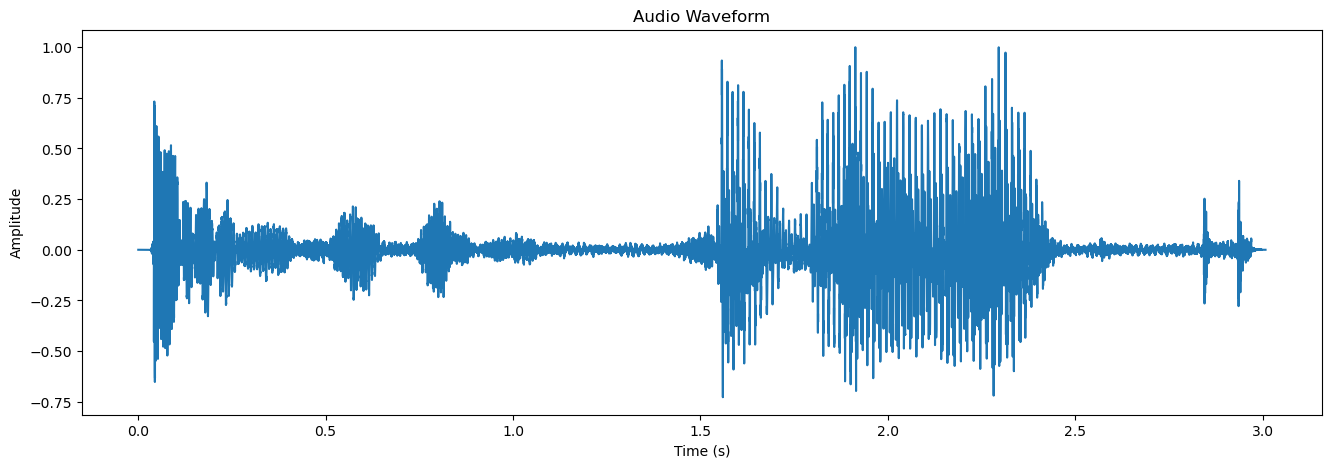

In [159]:
# Time-Domain Analysis
time = np.arange(0, len(src_norm)) / fs
plt.plot(time, src_norm)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

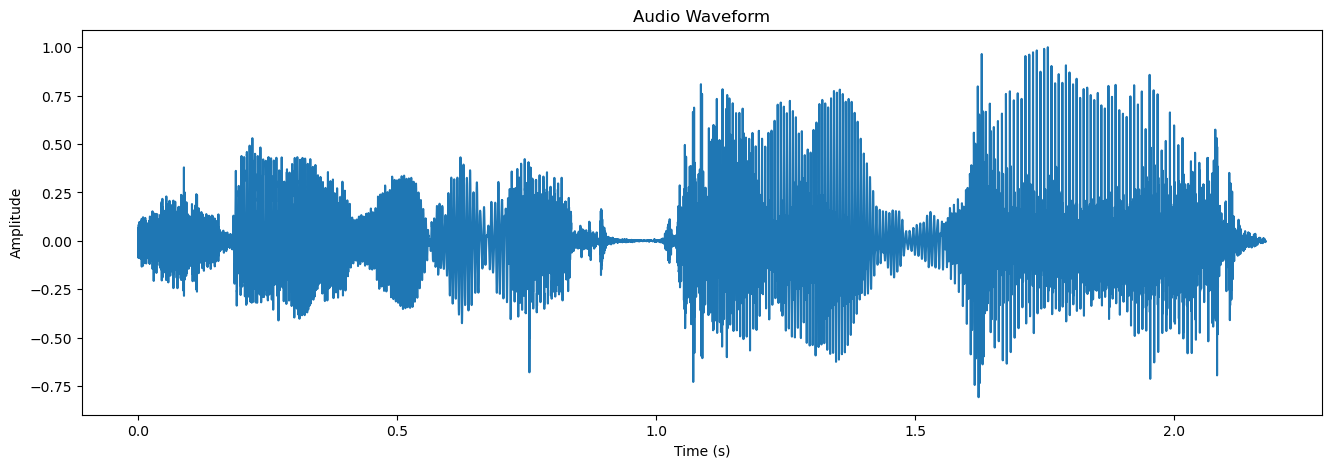

In [160]:
# Time-Domain Analysis
time = np.arange(0, len(dst_norm)) / fs
plt.plot(time, dst_norm)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

### removing noise

In [161]:
source_clean = nr.reduce_noise(src_norm, sr = fs)
target_clean = nr.reduce_noise(dst_norm, sr = fs)

In [162]:
IPython.display.display(Audio(source_audio, rate=fs))

In [163]:
IPython.display.display(Audio(source_clean, rate=fs))

In [164]:
IPython.display.display(Audio(target_audio, rate=fs))

In [165]:
IPython.display.display(Audio(target_clean, rate=fs))

### Extracting features

In [166]:
src_feat = collect_features(source_clean, fs_source)
dst_feat = collect_features(target_clean, fs_target)

# Features

In [167]:
pd.DataFrame(src_feat)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-16.000349,1.442477,0.442585,0.592715,0.266508,-0.092502,0.188828,-0.009841,-0.508798,0.013790,...,0.079882,0.019817,-0.127783,0.049150,0.082253,-0.159616,0.168578,-0.113539,0.040864,-0.030166
1,-14.619225,1.669172,0.608702,0.780561,0.410210,0.105330,-0.081470,0.012184,-0.419166,0.166742,...,0.107365,-0.007899,-0.101639,0.139106,-0.070351,-0.081347,0.108892,0.020231,-0.126165,0.071877
2,-13.800758,1.898681,0.788887,0.535787,0.227317,0.155083,0.019355,0.023084,-0.395565,-0.120201,...,0.063765,0.040484,-0.133222,0.088985,0.077389,-0.173445,0.073272,0.061200,-0.059875,-0.052805
3,-12.845532,1.504646,0.737265,0.647836,0.173076,0.108926,0.169252,0.094221,-0.533671,0.392568,...,0.090159,-0.086321,-0.023305,0.155858,-0.132619,-0.047757,0.153674,-0.097233,-0.024046,0.044690
4,-11.223982,1.645726,0.597640,0.637791,0.254274,-0.149389,-0.127300,0.034346,0.036084,-0.215704,...,0.094068,-0.095056,-0.049458,0.173666,-0.095171,-0.031504,0.007797,0.095550,-0.154283,0.094004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,-6.665529,-0.086847,1.082355,0.613670,-0.654980,-0.428224,-0.566517,-0.131125,-0.070405,0.867178,...,-0.024473,0.012182,0.163258,-0.224931,0.042908,0.040703,0.049027,-0.147525,0.168759,-0.161355
432,-8.567356,-0.955131,1.087961,0.263841,-0.411351,-0.392738,-0.839185,-0.277920,-0.333081,0.910137,...,0.177260,-0.028691,0.032679,-0.084657,0.020040,-0.035707,0.141942,-0.206215,0.192745,-0.168895
433,-10.223429,-1.408592,0.861715,0.413827,-0.519001,-0.004654,-0.739486,-0.203664,0.155496,0.789412,...,-0.030126,-0.052372,-0.002677,-0.048067,0.049368,-0.014945,0.034426,-0.034718,0.050622,-0.101736
434,-11.288391,-1.470269,1.178933,0.719259,-0.324147,-0.344195,-0.724994,-0.139843,-0.033027,0.540990,...,-0.061608,0.026883,-0.061860,0.125202,-0.193642,0.105872,0.094612,-0.207276,0.203973,-0.185668


In [168]:
scaler_src = MinMaxScaler()
scaler_src = scaler_src.fit(src_feat)
src = scaler_src.transform(src_feat)

scaler_dst = MinMaxScaler()
scaler_dst = scaler_dst.fit(dst_feat)
dst = scaler_dst.transform(dst_feat)

# Frame alignment using DTW

### Converting dataset to arrays

In [169]:
src_shape = src.shape
dst_shape = dst.shape

In [170]:
src_shape

(436, 25)

In [171]:
dst_shape

(316, 25)

In [172]:
max_frames = max(src_shape[0], dst_shape[0])

# Pad zeros for src and dst
src_padded = np.pad(src, ((0, max_frames - src_shape[0]), (0, 0)), 'constant')
dst_padded = np.pad(dst, ((0, max_frames - dst_shape[0]), (0, 0)), 'constant')

# src_padded = src_padded.T
# dst_padded = dst_padded.T

# Now, src_padded and dst_padded have the same shape
print("src_padded shape:", src_padded.shape)
print("dst_padded shape:", dst_padded.shape)

src_padded shape: (436, 25)
dst_padded shape: (436, 25)


In [173]:
pd.DataFrame(src_padded)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.503856,0.709555,0.673273,0.445245,0.457392,0.507733,0.577701,0.220922,0.508512,...,0.481788,0.600369,0.195686,0.769335,0.490656,0.345405,0.579890,0.412495,0.456781,0.618261
1,0.103875,0.530060,0.735547,0.730239,0.478046,0.506693,0.435821,0.584042,0.250284,0.553196,...,0.499596,0.580592,0.220424,0.851935,0.373979,0.405681,0.525335,0.545261,0.273470,0.723017
2,0.165433,0.556589,0.763741,0.656009,0.436299,0.519092,0.462645,0.587180,0.258016,0.469368,...,0.471345,0.615117,0.190540,0.805912,0.486937,0.334755,0.492777,0.585922,0.346221,0.595020
3,0.237276,0.511043,0.755664,0.689989,0.423918,0.507590,0.502525,0.607659,0.212774,0.619169,...,0.488447,0.524631,0.294547,0.867318,0.326371,0.431549,0.566268,0.428678,0.385543,0.695107
4,0.359234,0.527350,0.733816,0.686942,0.442453,0.443215,0.423628,0.590422,0.399420,0.441467,...,0.490980,0.518398,0.269801,0.883669,0.355003,0.444066,0.432930,0.620015,0.242611,0.745731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0.702079,0.327080,0.809661,0.679627,0.234909,0.373728,0.306775,0.542785,0.364535,0.757822,...,0.414172,0.594921,0.471082,0.517664,0.460574,0.499673,0.470616,0.378764,0.597143,0.483585
432,0.559041,0.226714,0.810538,0.573539,0.290519,0.382571,0.234232,0.500525,0.278485,0.770372,...,0.544884,0.565755,0.347522,0.646469,0.443090,0.440829,0.555544,0.320515,0.623468,0.475845
433,0.434486,0.174298,0.775137,0.619023,0.265947,0.479285,0.260757,0.521902,0.438538,0.735104,...,0.410509,0.548857,0.314067,0.680067,0.465513,0.456818,0.457270,0.490724,0.467490,0.544789
434,0.354390,0.167169,0.824772,0.711648,0.310424,0.394668,0.264612,0.540276,0.376780,0.662529,...,0.390110,0.605412,0.258066,0.839169,0.279716,0.549860,0.512282,0.319462,0.635790,0.458626


In [174]:
pd.DataFrame(dst_padded)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.309963,0.560652,0.604128,0.400088,0.630542,0.242872,0.500007,0.490802,0.536711,...,0.666360,0.242292,0.611633,0.660693,0.280823,0.849718,0.221239,0.688518,0.440501,0.467643
1,0.709078,0.057378,0.330763,0.918616,0.500693,0.834455,0.220800,0.569493,0.258893,0.350592,...,0.484652,0.415622,0.420180,0.829950,0.160416,0.935549,0.144957,0.888537,0.133781,0.782038
2,0.739789,0.076007,0.327293,0.908063,0.443413,0.801201,0.150386,0.621225,0.437606,0.443076,...,0.689661,0.185019,0.527024,0.935205,0.089160,0.934880,0.097643,0.949569,0.118738,0.761957
3,0.715603,0.061046,0.253738,0.887676,0.474571,0.841252,0.131479,0.687737,0.352461,0.430564,...,0.715966,0.129667,0.544838,0.917225,0.110155,0.921659,0.148969,0.839763,0.229503,0.717832
4,0.745109,0.076742,0.204523,0.902555,0.503869,0.883540,0.077503,0.664046,0.229892,0.538538,...,0.691082,0.163398,0.563690,0.796408,0.238629,0.843857,0.183296,0.851378,0.165989,0.821818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Vizualizing features

In [175]:
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, x_axis="time")
    colorbar()

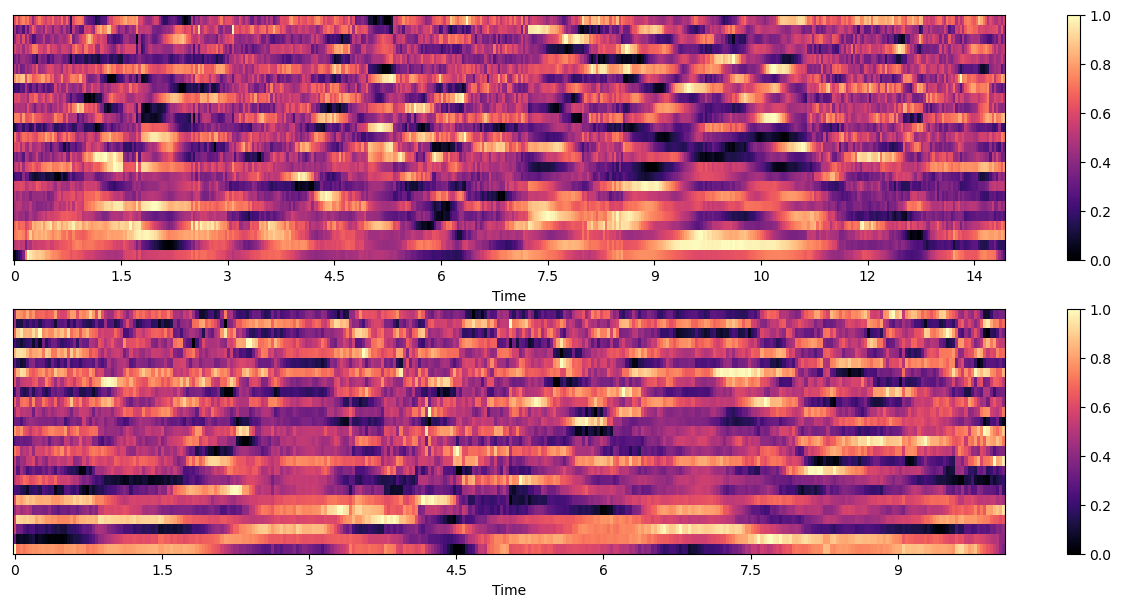

In [176]:
plot_parallel(src_padded,dst_padded)

In [180]:
# src_aligned, dst_aligned = DTWAligner(verbose=0, dist=melcd).transform((src_padded, dst_padded))

### Alignment of source and target features

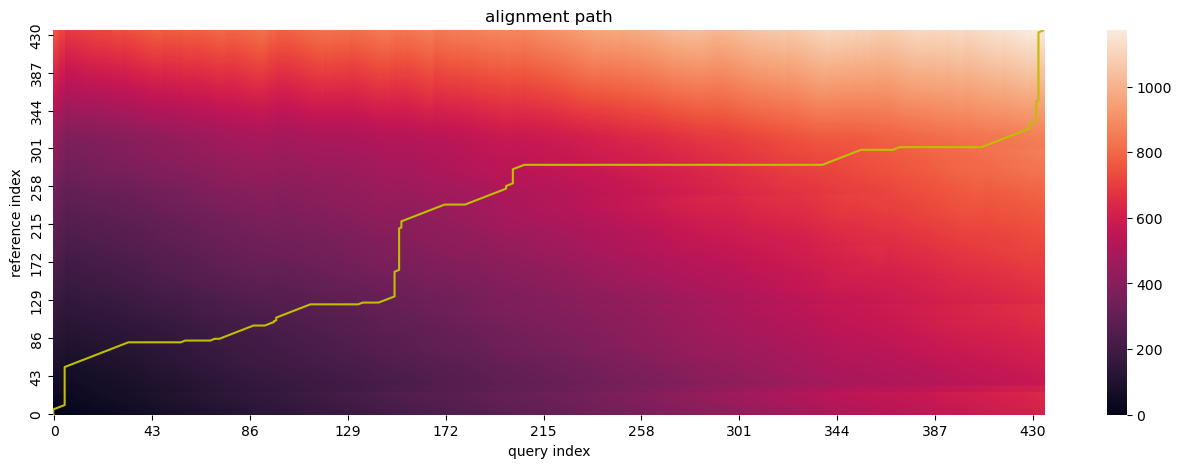

In [181]:
res = dtw(src_padded, dst_padded)
res.plot_path()

### Path Warping

In [182]:
x_path = res.path[:, 0]
y_path = res.path[:, 1]
x_warping_path = res.get_warping_path(target="query")

In [183]:
src_aligned = src_padded[x_warping_path]
dst_aligned = dst_padded

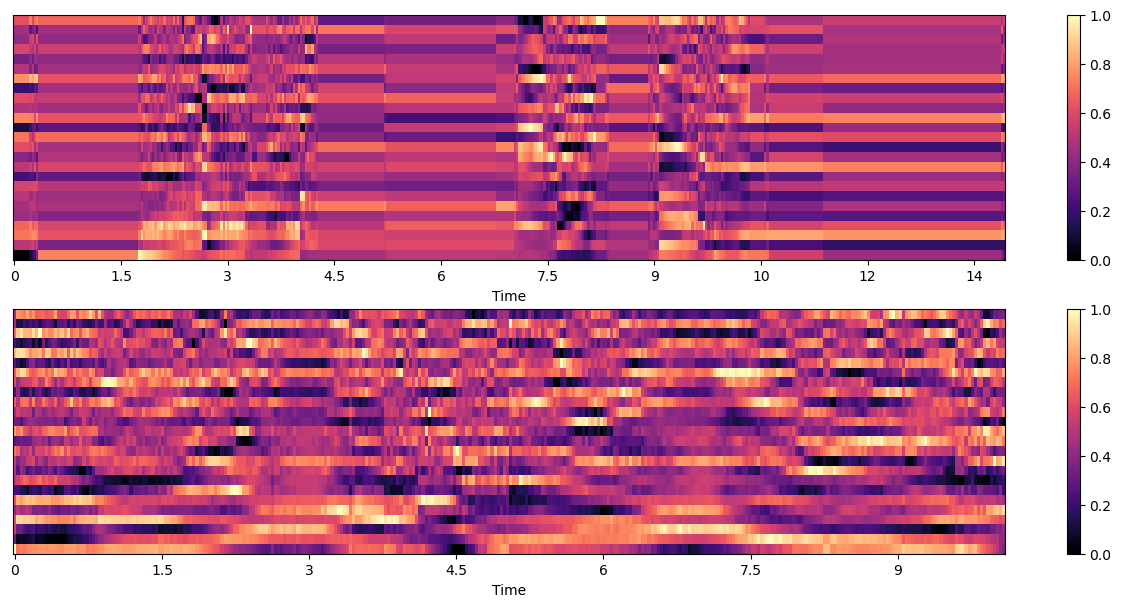

In [184]:
plot_parallel(src_aligned,dst_aligned)

### Appending delta fetures for higher quality audio

In [185]:
def _delta(x, window):
    return np.correlate(x, window, mode="same")

def delta(x, window):
    """Returns delta features given a static features and a window.

    Args:
        x (numpy.ndarray): Input static features, of shape (``T x D``).
        window (numpy.ndarray): Window coefficients.

    Returns:
        (ndarray): Delta features, shape (``T x D``).

    Examples:
        >>> from nnmnkwii.util import delta
        >>> T, static_dim = 10, 24
        >>> x = np.random.rand(T, static_dim)
        >>> window = np.array([-0.5, 0.0, 0.5]) # window for delta feature
        >>> y = delta(x, window)
        >>> assert x.shape == y.shape
    """
    T, D = x.shape
    y = np.zeros_like(x)
    for d in range(D):
        y[:, d] = _delta(x[:, d], window)
    return y

class UtteranceWiseTransformer(object):
    def transform(self, X, lengths=None):
        assert X.ndim == 3
        N, T, D = X.shape
        Y = np.zeros(self.get_shape(X), dtype=X.dtype)
        for idx, x in enumerate(X):
            if lengths is None:
                x = trim_zeros_frames(x)
            else:
                x = x[:lengths[idx]]
            y = self.do_transform(x)
            Y[idx][:len(y)] = y
        return Y

    def get_shape(self, X):
        raise NotImplementedError
    
class DeltaAppender(UtteranceWiseTransformer):
    """Append delta features.

    Given a ``N x T x D`` array, features of multiple utterances,
    transform features into static + delta features for each utterance.

    Attributes:
        windows (list): A sequence of windows. See
          :func:`nnmnkwii.functions.mlpg` for what window means.
    """

    def __init__(self, windows):
        self.windows = windows

    def get_shape(self, X):
        N, T, D = X.shape
        return (N, T, D * len(self.windows))

    def do_transform(self, x):
        features = []
        for _, _, window in self.windows:
            features.append(delta(x, window))
        combined_features = np.hstack(features)
        return combined_features


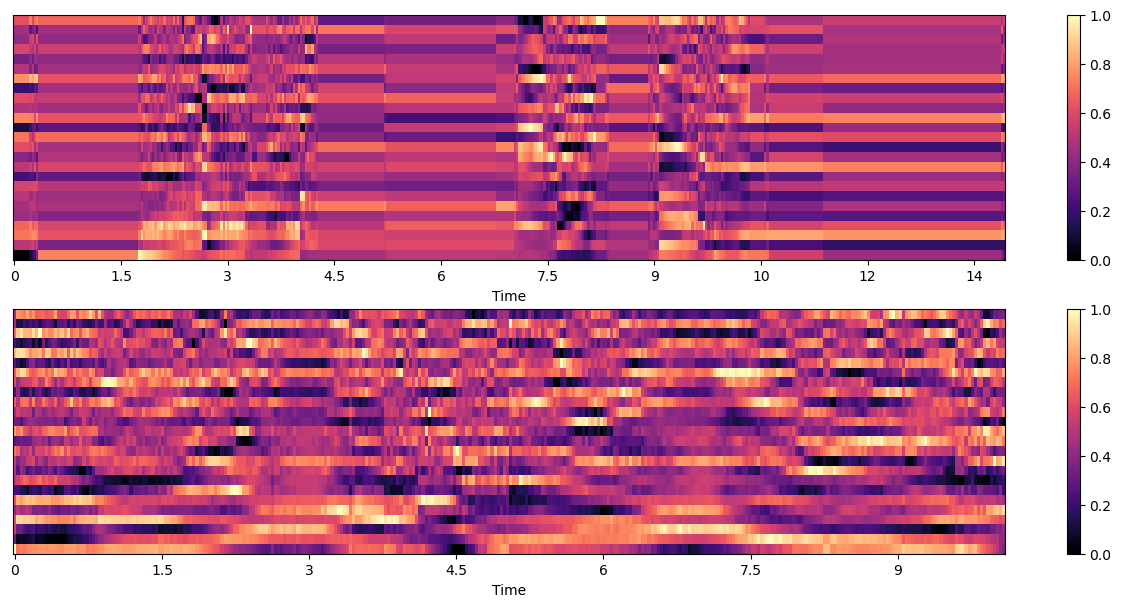

In [186]:
static_dim = src_aligned.shape[-1]
use_delta = False
if use_delta:
    src_aligned = DeltaAppender(windows).transform(src_aligned)
    dst_aligned = DeltaAppender(windows).transform(dst_aligned)

plot_parallel(src_aligned,dst_aligned)

### Getting Joint Feature Matrix

In [187]:
XY = np.concatenate((src_aligned, dst_aligned), axis=-1).reshape(-1, src_aligned.shape[-1]*2)
print(XY.shape)
XY = remove_zeros_frames(XY)    # remove padded zeros
print(XY.shape)

(436, 50)
(436, 50)


# Model

In [188]:
gmm = BayesianGaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1,random_state=10)

%time gmm.fit(XY)

Initialization 0
Initialization converged: True
CPU times: total: 1.19 s
Wall time: 136 ms


BayesianGaussianMixture(n_components=64, random_state=10, verbose=1)

In [213]:
with open("gmm.pkl", "wb") as file:
    pickle.dump(gmm, file)

In [189]:
# len(gmm.means_), len(gmm.covariances_)
gmm.means_.shape, gmm.covariances_.shape

((64, 50), (64, 50, 50))

### Vizualizing the model

### Means

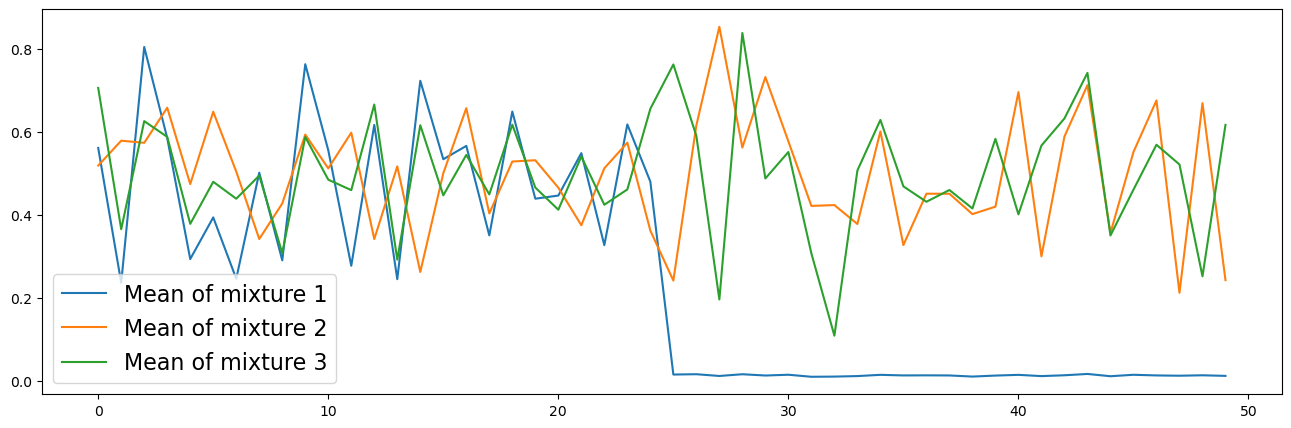

In [190]:
for k in range(3):
    plt.plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
plt.legend(prop={"size": 16})

### Covariances

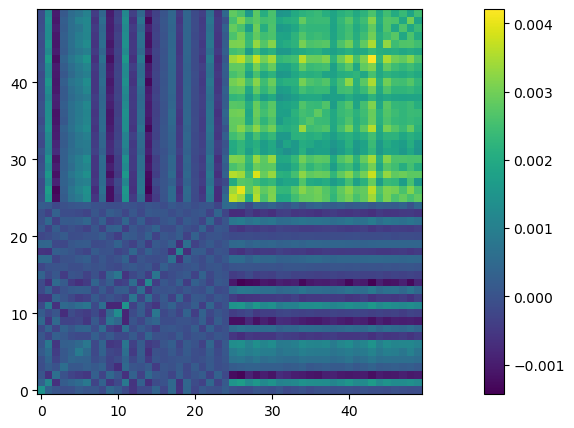

In [191]:
plt.imshow(gmm.covariances_[0], origin="lower")
plt.colorbar()

### Diagonal part of covariance matrix

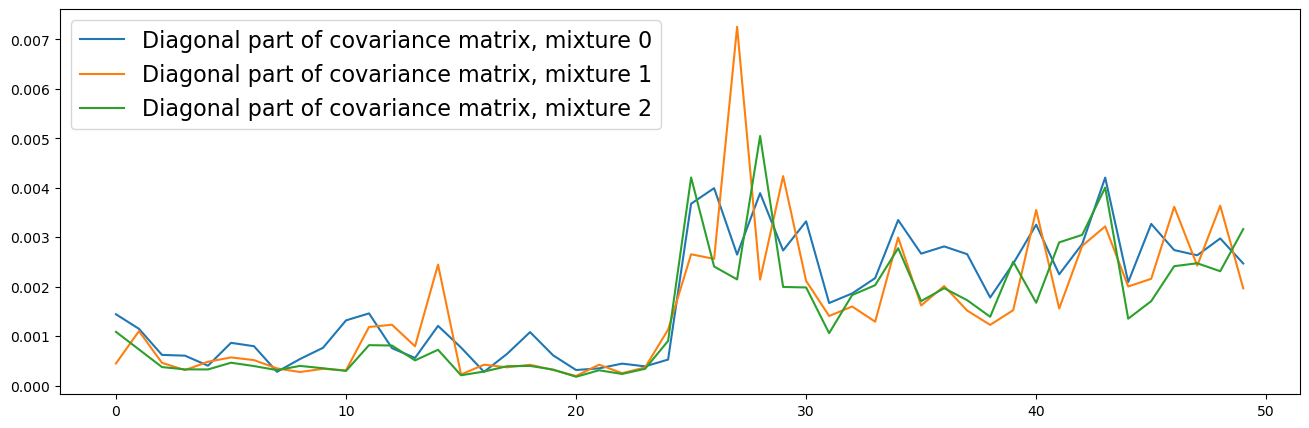

In [192]:
for k in range(3):
    plt.plot(np.diag(gmm.covariances_[k]), linewidth=1.5,
         label="Diagonal part of covariance matrix, mixture {}".format(k))
plt.legend(prop={"size": 16})

In [204]:
trimmed_test, _ = librosa.effects.trim(test_audio, top_db = 20)
test_norm = librosa.util.normalize(trimmed_test)

In [205]:
test_clean = nr.reduce_noise(test_norm, sr = fs_test)

In [206]:
IPython.display.display(Audio(test_clean, rate=fs))

In [207]:
IPython.display.display(Audio(target_clean, rate=fs))

In [209]:
paramgen = MLPG(gmm, windows=windows, diff=True)

In [212]:
src_aligned = paramgen.transform(test_audio)

IndexError: tuple index out of range

In [60]:
scaler_test = MinMaxScaler()
scaler_test = scaler_test.fit(test_mfccs)
test = scaler_test.transform(test_mfccs)

In [61]:
pd.DataFrame(test)

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.988534,0.965202,0.916579,0.693078,0.633886,0.706296,0.696425,0.660556,0.748279,0.942129
2,0.915827,0.901809,0.904442,0.872082,0.835331,0.853284,0.856943,0.884143,0.920151,0.940323,...,0.978801,0.949777,0.946555,1.000000,1.000000,0.978521,0.990889,1.000000,1.000000,1.000000
3,0.761827,0.630736,0.654748,0.796826,0.830200,0.862557,0.878574,0.894857,0.928919,0.954571,...,0.997454,1.000000,0.979064,0.838749,0.808594,0.829184,0.782142,0.744718,0.786519,0.923776
4,0.747575,0.588577,0.575080,0.675938,0.726268,0.769657,0.828591,0.885625,0.933523,0.950175,...,1.000000,0.988620,0.950164,0.847261,0.821080,0.852654,0.798430,0.749750,0.801300,0.940216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.799679,0.676410,0.668339,0.717204,0.729045,0.753792,0.771679,0.801662,0.834203,0.869038,...,0.989438,0.977053,0.958338,0.903567,0.897022,0.915787,0.881316,0.857300,0.887307,0.965709
61,0.793458,0.662837,0.660367,0.712953,0.721044,0.744241,0.759421,0.795326,0.832935,0.864186,...,0.990560,0.976244,0.962501,0.898840,0.890178,0.909170,0.894106,0.870623,0.897628,0.962052
62,0.785163,0.658146,0.661183,0.729872,0.738555,0.749183,0.768662,0.794957,0.837360,0.868517,...,0.993842,0.980804,0.965814,0.907590,0.896654,0.907429,0.876791,0.854768,0.889291,0.972393
63,0.807286,0.684270,0.671181,0.715711,0.730022,0.745254,0.774364,0.796109,0.832272,0.867751,...,0.989774,0.977449,0.961271,0.900537,0.889597,0.896604,0.877519,0.862279,0.895338,0.963198


In [62]:
test_shape = test.shape
dst_shape = dst.shape
max_frames = max(test_shape[0], dst_shape[0])

# Pad zeros for src and dst
test_padded = np.pad(test, ((0, max_frames - test_shape[0]), (0, 0)), 'constant')
dst_padded = np.pad(dst, ((0, max_frames - dst_shape[0]), (0, 0)), 'constant')

test_padded = test_padded.T
dst_padded = dst_padded.T

# Now, src_padded and dst_padded have the same shape
print("test_padded shape:", test_padded.shape)
print("dst_padded shape:", dst_padded.shape)

test_padded shape: (95, 65)
dst_padded shape: (69, 65)


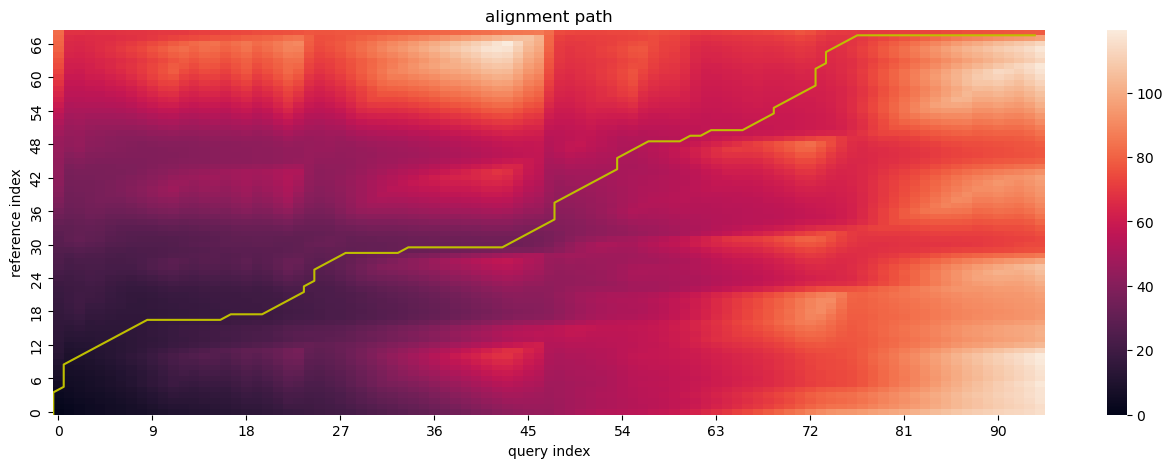

In [63]:
res = dtw(test_padded, dst_padded)
res.plot_path()

In [64]:
test_path = res.path[:, 0]
dst_path = res.path[:, 1]

In [65]:
test_warping_path = res.get_warping_path(target="query")
test_aligned = test_padded[test_warping_path]
dst_aligned = dst_padded

In [66]:
# Append delta features if use_delta is True
static_dim = test_aligned.shape[-1]
use_delta = True  # Set this to True if you want to use delta features

if use_delta:
    test_aligned_delta = delta(test_aligned)
    dst_aligned_delta = delta(dst_aligned)
    
    # Append the delta features to the original features
    test_aligned = np.concatenate([test_aligned, test_aligned_delta], axis=-1)
    dst_aligned = np.concatenate([dst_aligned, dst_aligned_delta], axis=-1)

# Print the shapes of aligned sequences
print("X_aligned shape:", test_aligned.shape)
print("Y_aligned shape:", dst_aligned.shape)

X_aligned shape: (69, 130)
Y_aligned shape: (69, 130)


In [67]:
# Find the minimum second dimension
min_dim = min(test_aligned.shape[1], dst_aligned.shape[1])

# Concatenate and reshape
XY_test = np.concatenate((test_aligned[:, :min_dim], dst_aligned[:, :min_dim]), axis=-1).reshape(-1, min_dim * 2)

print(XY_test.shape)

(69, 260)


### Implementing MLPG

In [68]:
paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=True)

In [69]:
src_aligned
src_aligned = paramgen.transform(test_aligned)

### Extracting audio from converted features

In [70]:
scaler_converted = MinMaxScaler()
scaler_converted = scaler_converted.fit(test_aligned)
XY_test_converted = scaler_converted.transform(test_aligned)

In [71]:
XY_test_converted_invert = scaler_converted.inverse_transform(XY_test_converted)
XY_test_inverse = librosa.feature.inverse.mfcc_to_audio(XY_test_converted_invert)
IPython.display.Audio(XY_test_inverse, rate=fs_test)

In [72]:
XY_test_inverse_nr = nr.reduce_noise(XY_test_inverse, sr = fs_target)
IPython.display.Audio(XY_test_inverse_nr, rate=fs_test)